# Exploratory Data Analysis & Fraud Detection

This notebook analyzes trading and user activity data to:
- Understand market activity
- Analyze BTC price volatility
- Study user deposit behavior
- Identify suspicious (fraud-like) users


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

trades = pd.read_csv("data/trades.csv")
activity = pd.read_csv("data/user_activitycsv.csv")

trades["timestamp"] = pd.to_datetime(trades["timestamp"])
activity["timestamp"] = pd.to_datetime(activity["timestamp"])


## Part 1: Exploratory Data Analysis

This section explores market activity, price volatility, and user deposit behavior.


In [2]:
trades["usd_volume"] = trades["amount"] / 1500

pair_volume = trades.groupby("pair")["usd_volume"].sum()
top_3_pairs = pair_volume.sort_values(ascending=False).head(3)
top_3_pairs


pair
BTCNGN     136215.488680
USDTNGN     59180.573580
ETHNGN       9764.589513
Name: usd_volume, dtype: float64

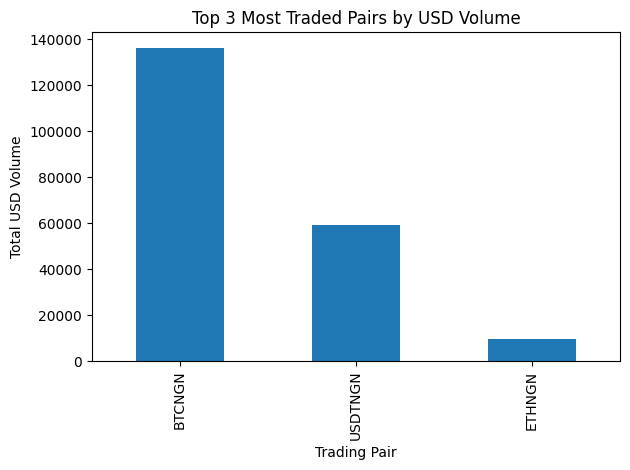

In [3]:
plt.figure()
top_3_pairs.plot(kind="bar")
plt.title("Top 3 Most Traded Pairs by USD Volume")
plt.xlabel("Trading Pair")
plt.ylabel("Total USD Volume")
plt.tight_layout()
plt.show()


### BTC Price Volatility

Daily price volatility is calculated using the standard deviation of BTC prices,
with a 7-day rolling average applied to smooth trends.


In [4]:
btc_trades = trades.loc[trades["pair"] == "BTCNGN"].copy()
btc_trades["price"] = btc_trades["amount"] / btc_trades["volume"]

btc_trades["date"] = btc_trades["timestamp"].dt.date
daily_volatility = btc_trades.groupby("date")["price"].std()

daily_volatility_df = daily_volatility.reset_index()
daily_volatility_df.columns = ["date", "daily_price_volatility"]

daily_volatility_df = daily_volatility_df.sort_values("date")
daily_volatility_df["volatility_7d_avg"] = (
    daily_volatility_df["daily_price_volatility"]
    .rolling(window=7)
    .mean()
)

daily_volatility_df.tail()


,date,daily_price_volatility,volatility_7d_avg
12,2024-12-09,2.075616e+06,1.872897e+06
13,2024-12-10,1.002608e+06,1.777541e+06
14,2024-12-11,7.464418e+05,1.602758e+06
15,2025-03-11,1.753777e+06,1.295043e+06
16,2025-07-18,8.727070e+05,1.322225e+06


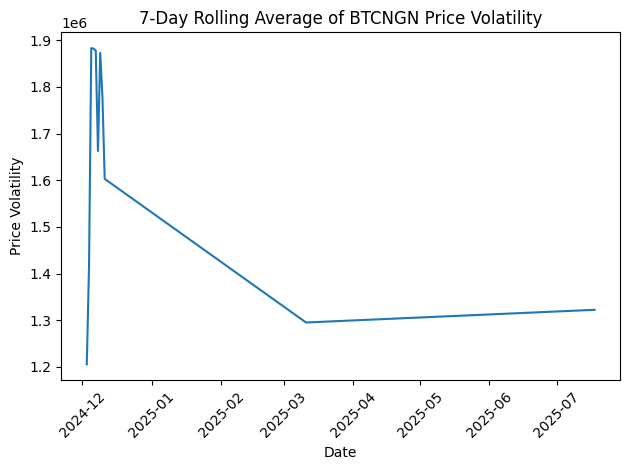

In [5]:
plt.figure()
plt.plot(
    daily_volatility_df["date"],
    daily_volatility_df["volatility_7d_avg"]
)
plt.title("7-Day Rolling Average of BTCNGN Price Volatility")
plt.xlabel("Date")
plt.ylabel("Price Volatility")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### User Deposit Behavior

This section analyzes when users are most likely to deposit funds.


In [6]:
deposits = activity.loc[
    activity["activity_type"] == "deposit"
].copy()

deposits["day_of_week"] = deposits["timestamp"].dt.day_name()
deposits["hour"] = deposits["timestamp"].dt.hour

deposits_by_day = (
    deposits.groupby("day_of_week")["amount"]
    .sum()
    .sort_values(ascending=False)
)

deposits_by_hour = (
    deposits.groupby("hour")["amount"]
    .sum()
)

deposits_by_day, deposits_by_hour


(day_of_week
 Friday       2.314969e+07
 Wednesday    1.849214e+07
 Saturday     1.550753e+07
 Monday       2.182000e+04
 Sunday       3.150000e+03
 Thursday     2.983444e+01
 Name: amount, dtype: float64,
 hour
 0     7.888382e+04
 1     4.224380e+04
 2     5.021891e+02
 3     4.550902e+04
 4     2.164225e+05
 5     2.222451e+05
 6     2.965273e+06
 7     1.252926e+06
 8     2.314144e+06
 9     4.613537e+06
 10    1.204685e+06
 11    6.899667e+06
 12    8.781662e+06
 13    8.723062e+05
 14    3.649478e+05
 15    6.657647e+06
 16    4.496001e+06
 17    4.967763e+06
 18    2.740936e+06
 19    2.712505e+06
 20    3.676664e+06
 21    1.367471e+06
 22    2.183134e+05
 23    4.620988e+05
 Name: amount, dtype: float64)

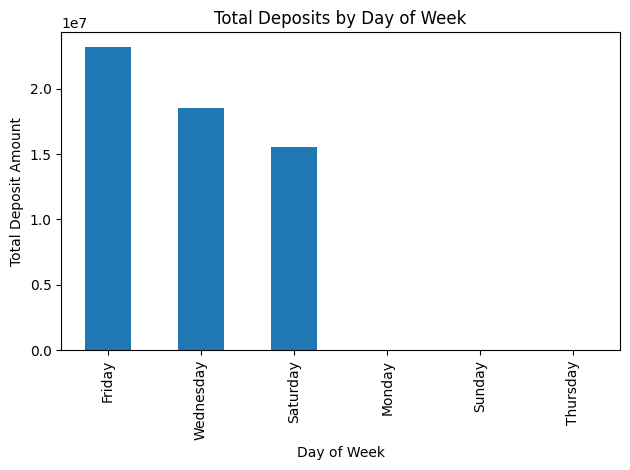

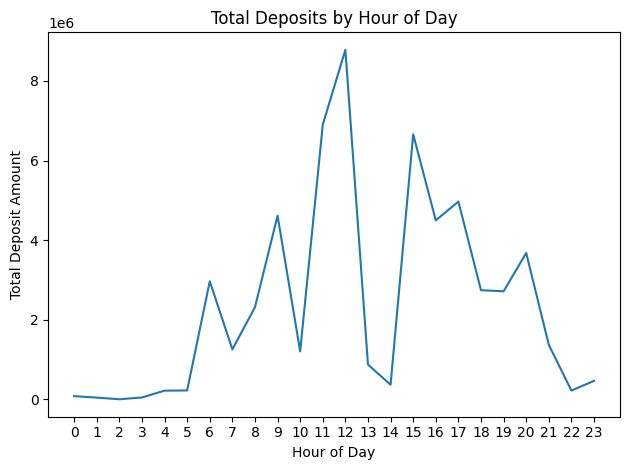

In [7]:
plt.figure()
deposits_by_day.plot(kind="bar")
plt.title("Total Deposits by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Total Deposit Amount")
plt.tight_layout()
plt.show()

plt.figure()
deposits_by_hour.plot(kind="line")
plt.title("Total Deposits by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Total Deposit Amount")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


## Part 2: Fraud Detection Model

This section identifies suspicious users based on deposit, trading,
and withdrawal behavior.


In [8]:
# Total deposits per user
user_deposits = (
    activity[activity["activity_type"] == "deposit"]
    .groupby("user_id")["amount"]
    .sum()
)

# Total withdrawals per user
user_withdrawals = (
    activity[activity["activity_type"] == "withdrawal"]
    .groupby("user_id")["amount"]
    .sum()
)

# Combine deposits and withdrawals
user_activity_summary = pd.concat(
    [user_deposits, user_withdrawals],
    axis=1
)

user_activity_summary.columns = [
    "total_deposited",
    "total_withdrawn"
]

user_activity_summary = user_activity_summary.fillna(0)

user_activity_summary.head()

,total_deposited,total_withdrawn
user_id,,
1001-11001-1521-1561-154,100150.002099,431339.0
1001-11001-1521-1571-155,0.000267,32888.0
1001-11001-1521-1971-1102,0.000242,40300.0
1001-11001-1521-1981-156,0.172140,93089.0
1001-11001-1521-1981-157,0.001116,84006.0


In [9]:
# Total trading amount per user
user_trade_volume = (
    trades.groupby("user_id")["amount"]
    .sum()
)

# Number of unique trading pairs per user
user_unique_assets = (
    trades.groupby("user_id")["pair"]
    .nunique()
)

# Merge trading features with activity summary
user_features = user_activity_summary.join(
    [user_trade_volume, user_unique_assets],
    how="left"
)

user_features.columns = [
    "total_deposited",
    "total_withdrawn",
    "total_traded",
    "unique_assets_traded"
]

user_features = user_features.fillna(0)

user_features.head()

,total_deposited,total_withdrawn,total_traded,unique_assets_traded
user_id,,,,
1001-11001-1521-1561-154,100150.002099,431339.0,27484.11,1
1001-11001-1521-1571-155,0.000267,32888.0,71703.21,1
1001-11001-1521-1971-1102,0.000242,40300.0,70009.30,1
1001-11001-1521-1981-156,0.172140,93089.0,7410.24,1
1001-11001-1521-1981-157,0.001116,84006.0,656025.82,1


In [10]:
# First deposit time per user
first_deposit_time = (
    activity[activity["activity_type"] == "deposit"]
    .groupby("user_id")["timestamp"]
    .min()
)

# First withdrawal time per user
first_withdrawal_time = (
    activity[activity["activity_type"] == "withdrawal"]
    .groupby("user_id")["timestamp"]
    .min()
)

# Time difference in hours
time_to_withdrawal = (
    (first_withdrawal_time - first_deposit_time)
    .dt.total_seconds() / 3600
)

user_features["hours_to_first_withdrawal"] = time_to_withdrawal
user_features["hours_to_first_withdrawal"] = (
    user_features["hours_to_first_withdrawal"].fillna(9999)
)

user_features.head()

,total_deposited,total_withdrawn,total_traded,unique_assets_traded,hours_to_first_withdrawal
user_id,,,,,
1001-11001-1521-1561-154,100150.002099,431339.0,27484.11,1,-2.692500
1001-11001-1521-1571-155,0.000267,32888.0,71703.21,1,0.380501
1001-11001-1521-1971-1102,0.000242,40300.0,70009.30,1,0.563419
1001-11001-1521-1981-156,0.172140,93089.0,7410.24,1,-0.032768
1001-11001-1521-1981-157,0.001116,84006.0,656025.82,1,0.272756


In [11]:
user_features["withdraw_ratio"] = (
    user_features["total_withdrawn"] /
    user_features["total_deposited"]
)

user_features["trade_ratio"] = (
    user_features["total_traded"] /
    user_features["total_deposited"]
)

user_features["is_suspicious"] = (
    (user_features["withdraw_ratio"] >= 0.9) &
    (user_features["trade_ratio"] <= 0.1) &
    (user_features["hours_to_first_withdrawal"] <= 24)
).astype(int)

user_features["is_suspicious"].value_counts()

is_suspicious
0    1194
1       5
Name: count, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, precision_score

features = [
    "total_deposited",
    "total_withdrawn",
    "total_traded",
    "unique_assets_traded",
    "hours_to_first_withdrawal",
]

X = user_features[features]
y = user_features["is_suspicious"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       359
           1       0.50      1.00      0.67         1

    accuracy                           1.00       360
   macro avg       0.75      1.00      0.83       360
weighted avg       1.00      1.00      1.00       360

Recall: 1.0
Precision: 0.5


## Strategic Recommendation: Low-Volume Trader Campaign (Kenya)

### Target Audience Definition
The target audience for the Low-Volume Trader campaign consists of users who are already active on the platform but trade in small amounts and do so infrequently. These users have deposited funds and made some trades, showing interest in trading, but have not yet become regular or high-volume traders. This makes them suitable for targeted marketing aimed at increasing engagement.

### Key Data Points to Create This User Segment

1. **Trading Volume Relative to Deposited Amount**  
   Users whose total trading volume is low compared to the amount they have deposited. This suggests that they are cautious or unsure and may need incentives or education to trade more.

2. **Trading Frequency Over Time**  
   Users who place trades infrequently, such as only a few times per week or month. This helps identify users with low engagement rather than completely inactive users.

3. **Asset Diversity**  
   Users who trade only one or two assets or trading pairs. This often indicates beginner-level behavior, making them good candidates for beginner-friendly campaigns and guidance.

### Why This Is Data-Driven
These data points are easy to measure using existing platform data, are simple to validate from a QA perspective, and directly reflect real user behavior. Using them allows the product team to target the right users while minimizing risk and unnecessary outreach.


## Part 2: Fraud Detection Model

### Introduction

In this task, my goal was to identify **suspicious users** on a trading platform.  
A common fraud pattern described is when a user **deposits money, makes very little or no trades, and then quickly withdraws most or all of the funds**.

Since there was **no existing fraud label** in the dataset, I approached the problem by:

- Creating user-level features from raw transaction data  
- Defining a clear rule to label suspicious users  
- Training a machine learning model to learn this behavior  


## 1. Feature Engineering

To detect fraud, I first transformed the data so that **each row represents one user** instead of individual transactions. This makes it easier to analyze overall user behavior.

### Deposit and Withdrawal Features
- Total amount deposited by each user  
- Total amount withdrawn by each user  

These features help identify users who withdraw a large portion of their deposits.


### Trading Activity Features
- Total trading amount per user  
- Number of unique trading pairs used  

These features show whether a user actually trades or mainly moves money in and out of the platform.


### Time-Based Feature
- Time (in hours) between a user’s first deposit and first withdrawal  

This is important because fraudulent users often withdraw funds very quickly after depositing.


### Ratio Features
To make user behavior easier to compare across users, I created:
- Withdrawal-to-deposit ratio  
- Trading-to-deposit ratio  

These ratios help highlight users who withdraw most of their money while trading very little.


## 2. Target Labeling (Defining Fraud)

Since the dataset did not include an `is_fraud` column, I created a **rule-based fraud label** using the behavior described in the problem.

A user was labeled as **suspicious (1)** if:
- They withdrew **90% or more** of their deposited funds  
- They traded **less than 10%** of what they deposited  
- Their first withdrawal happened **within 24 hours** of their first deposit  

All other users were labeled as **non-suspicious (0)**.

This rule-based approach allowed me to create a realistic and explainable target variable based on domain understanding.


## 3. Model Building

After preparing the features and labels, I trained a **Logistic Regression** model to classify users as suspicious or not.

I chose Logistic Regression because:
- It is simple and easy to interpret  
- It works well as a baseline classification model  
- It clearly shows how user behavior affects predictions  

The dataset was split into training and testing sets before fitting the model.


## 4. Model Evaluation

Fraud detection is a **highly imbalanced problem**, since fraudulent users are much fewer than legitimate users. Because of this, accuracy is not a reliable metric.

### Precision vs Recall
- **Precision** measures how many flagged users are actually fraud  
- **Recall** measures how many actual fraud cases are correctly detected  

In this context, **recall is more important than precision** because:
- Missing a fraudulent user can lead to financial loss  
- Investigating some false positives is acceptable  

Therefore, I focused mainly on **recall** when evaluating the model.


## Conclusion

This approach demonstrates a practical and realistic fraud detection workflow:

- Converting raw transaction data into meaningful user-level features  
- Defining a clear and explainable fraud rule  
- Training a classification model to detect suspicious behavior  
- Evaluating the model using business-appropriate metrics  

Overall, the solution balances simplicity, interpretability, and real-world relevance.


## What This Project Tries to Answer

### 1. Market Activity
- Which trading pairs are used the most  
- All values are converted to USD using a fixed rate (**1 USD = 1500 NGN**)


### 2. Price Volatility
- How much does the price of BTC change each day  
- A **7-day moving average** is used to make price trends easier to understand


### 3. User Behavior
- On which days users deposit the most  
- At what hours deposits are highest  

Charts are used to clearly show these patterns.


## Tools Used
- **Python**
- **Pandas** for working with data
- **Matplotlib** for creating charts


## How to Run the Project

1. Open the project folder  
2. Make sure Python is installed  
3. Install the required libraries:
   ```bash
   pip install pandas matplotlib
````

4. Run the analysis:

   ```bash
   python analysis.py
   ```

This will load the data and display the charts.


## Key Findings

* **BTCNGN** is the most active trading pair
* BTC price changes frequently, but trends become clearer when using a 7-day average
* Users tend to deposit more on certain days and at specific times of the day

## What I Learned

* How to read and explore CSV data
* How to work with dates and time using Pandas
* How to group and summarize data
* How to create simple charts to explain insights
* How to turn raw data into useful information

```
```
